In [ ]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 47.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.51MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.65MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
print(train_ds.data.shape)
print(train_ds.targets.shape)
print(train_ds.classes)
print(train_ds.data[0])
print(train_ds.targets[0])
print(train_ds.data[0].max())
print(train_ds.data[0].min())
print(train_ds.data[0].float().mean())
print(train_ds.data[0].float().std())

torch.Size([60000, 28, 28])
torch.Size([60000])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   

In [4]:
# Build dataloader
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Discriminator will down-sample the input producing a binary output
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # Rehape passed image batch
        batch_size = x.shape[0] #input tensor
        x = x.view(batch_size, -1)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)
        logit_out = self.fc4(x)

        return logit_out

### Generator Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features #input noise
        self.out_features = out_features

        # Generator will up-sample the input producing input of size
        # suitable for feeding into discriminator
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()


    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)

        return tanh_out

In [ ]:
def real_loss(predicted_outputs, loss_fn, device):
    
    batch_size = predicted_outputs.shape[0]
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)

    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    
    batch_size = predicted_outputs.shape[0]
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)

    return fake_loss

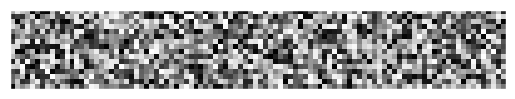

In [ ]:
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Training loop function

def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')

    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)
    fixed_samples = []
    d_losses = []
    g_losses = []

    d = d.to(device)
    g = g.to(device)

    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            real_images = real_images.to(device)
            d_optim.zero_grad()
            real_images = (real_images * 2) - 1
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            #d_real_loss = real_loss(d_real_logits_out, smooth=True)

            # Fake images
            with torch.no_grad():
                
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                
                fake_images = g(z)
            
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optim.step()
            d_running_batch_loss += d_loss

            # Reset gradients
            g_optim.zero_grad()

            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            fake_images = g(z)
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            g_loss.backward()
            g_optim.step()
            
            g_running_batch_loss += g_loss

            

        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)

        # Display training stats for every 200 batches
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')

        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())

    
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)

    return d_losses, g_losses

In [12]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
#g = Generator(100, 32, 784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim,
                                     loss_fn, dl, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cuda]...
Epoch [1/100]:
epoch_d_loss: 1.175029 	epoch_g_loss: 1.526589
Epoch [2/100]:
epoch_d_loss: 1.2

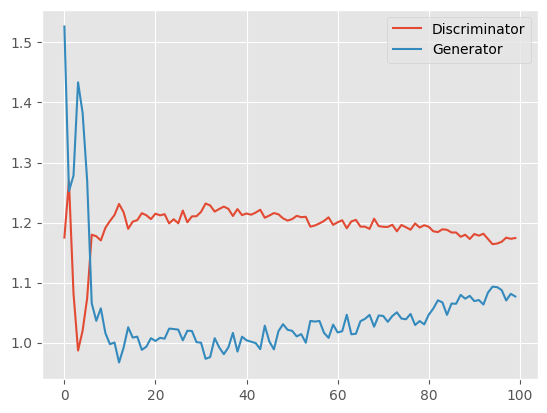

In [13]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [14]:
##
## Visualize image generation improvements
##

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

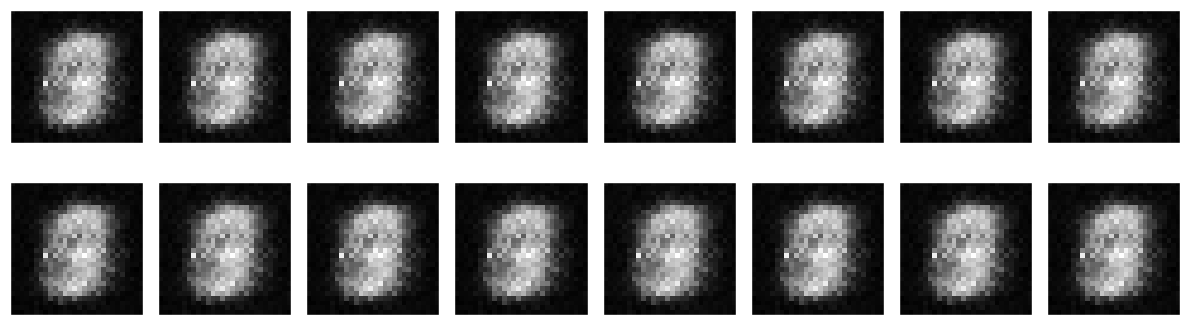

In [15]:
show_generated_images(epoch=1, n_cols=8)

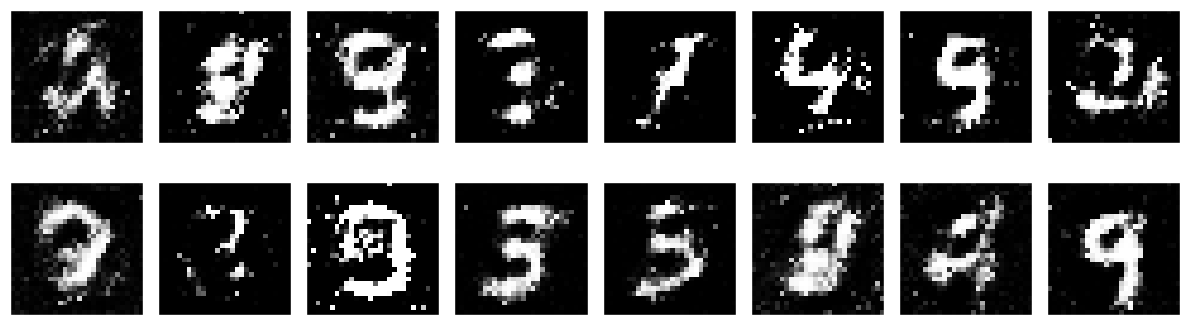

In [16]:
show_generated_images(epoch=10, n_cols=8)

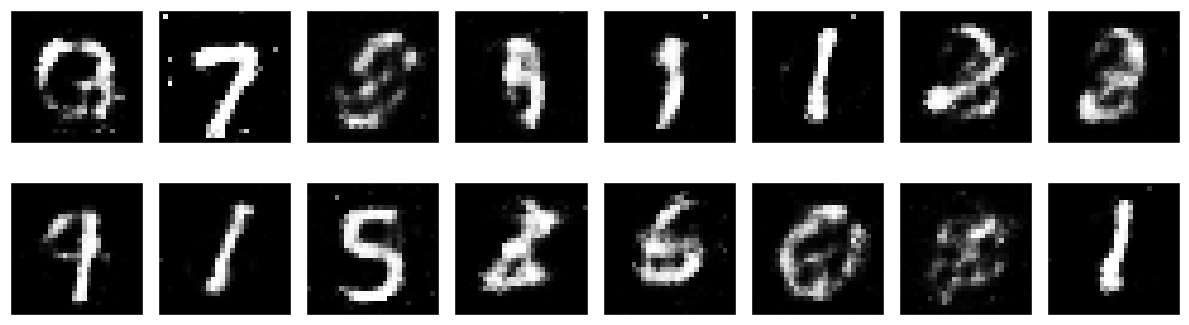

In [17]:
show_generated_images(epoch=50, n_cols=8)

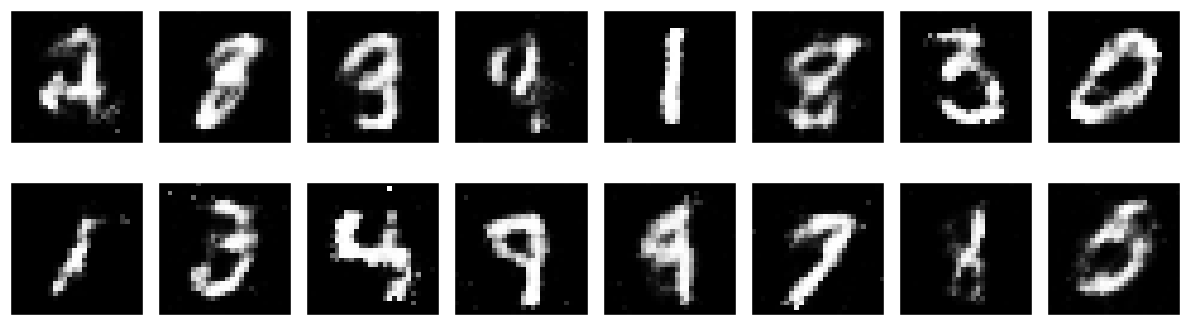

In [18]:
show_generated_images(epoch=100, n_cols=8)

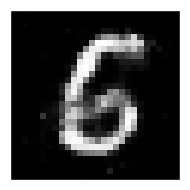

In [20]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))

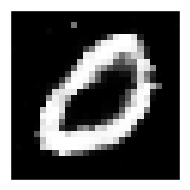

In [22]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))

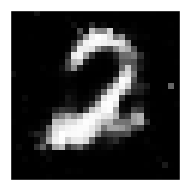

In [23]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))

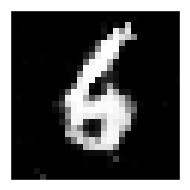

In [24]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))